# 10 Exercise MobileNet Flowers

PyTorch: 2.10.0+cu128
Torchvision: 0.25.0+cu128
Device: cuda
GPU disponibile: True


100%|██████████| 170M/170M [00:05<00:00, 32.0MB/s]


Training set: (50000, 32, 32, 3)
Test set: (10000, 32, 32, 3)
Range valori: [0, 255]
Classi: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


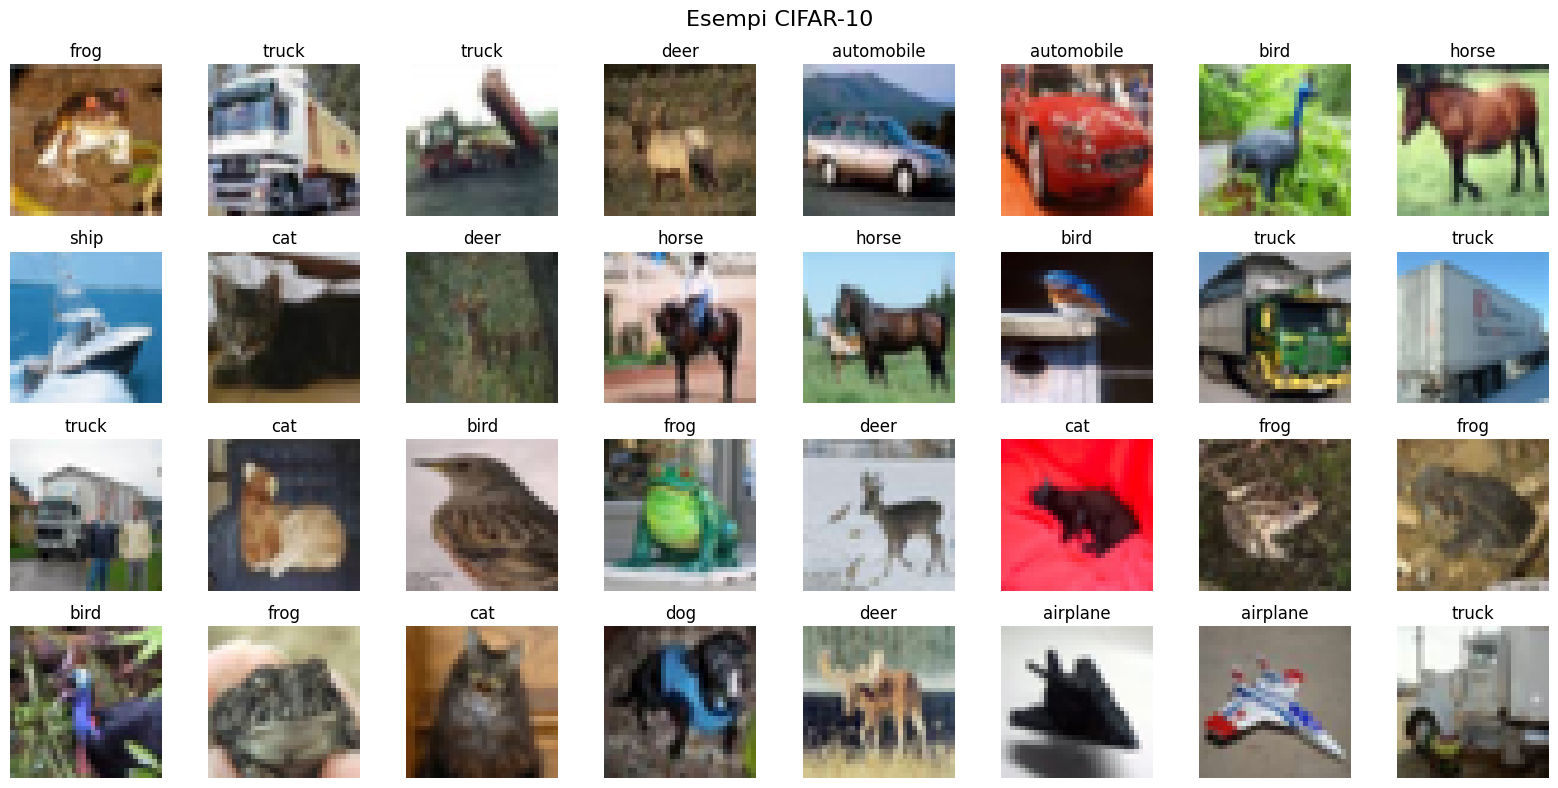

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"Device: {device}")
print(f"GPU disponibile: {torch.cuda.is_available()}")

# Caricamento CIFAR-10
transform_basic = transforms.ToTensor()

trainset_full = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=transform_basic
)
testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=transform_basic
)

# Per avere anche array numpy (utile per visualizzazioni)
trainset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=None
)
testset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=None
)

# Nomi classi CIFAR-10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Estrai dati come numpy per preprocessing/visualizzazione
X_train = np.array([np.array(img) for img, _ in trainset_raw])
y_train = np.array([label for _, label in trainset_raw])
X_test = np.array([np.array(img) for img, _ in testset_raw])
y_test = np.array([label for _, label in testset_raw])

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Range valori: [{X_train.min()}, {X_train.max()}]")
print(f"Classi: {class_names}")

# Visualizzazione esempi
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(class_names[y_train[i]])
    ax.axis('off')
plt.suptitle('Esempi CIFAR-10', fontsize=16)
plt.tight_layout()
plt.show()

import os, urllib.request

# GitHub Release URL for pretrained weights (update with actual URL)
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    return history

In [2]:
# Normalizzazione a [0,1]
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Converti in tensori PyTorch (NCHW format)
X_train_tensor = torch.from_numpy(X_train_norm).permute(0, 3, 1, 2)  # NHWC -> NCHW
X_test_tensor = torch.from_numpy(X_test_norm).permute(0, 3, 1, 2)
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()

print("Shape dopo preprocessing:")
print(f"  X_train tensor: {X_train_tensor.shape}")
print(f"  y_train tensor: {y_train_tensor.shape}")
print(f"Range valori: [{X_train_tensor.min():.2f}, {X_train_tensor.max():.2f}]")

Shape dopo preprocessing:
  X_train tensor: torch.Size([50000, 3, 32, 32])
  y_train tensor: torch.Size([50000])
Range valori: [0.00, 1.00]


In [ ]:
def train_model(model, train_loader, val_loader, epochs=5,
                lr=0.001, patience=5, patience_lr=3, device=device):
    """
    Training loop generico PyTorch con early stopping e ReduceLROnPlateau.
    Restituisce un dizionario con history (come Keras).
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=patience_lr, min_lr=1e-7
    )

    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        scheduler.step(val_loss)

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"loss: {train_loss:.4f} - accuracy: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

In [ ]:
def evaluate_model(model, X_tensor, y_tensor, device=device):
    """Evaluate model and return loss, accuracy, predictions."""
    model.eval()
    test_dataset = TensorDataset(X_tensor, y_tensor)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.append(predicted.cpu())
            all_probs.append(probs.cpu())

    test_loss = test_loss / total
    test_acc = correct / total
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()
    return test_loss, test_acc, all_preds, all_probs

## Esercizio 4

Dataset Flowers
Train: (700, 96, 96, 3), Val: (150, 96, 96, 3), Test: (150, 96, 96, 3)
Classi: ['Rose', 'Sunflower', 'Tulip', 'Daisy', 'Iris']


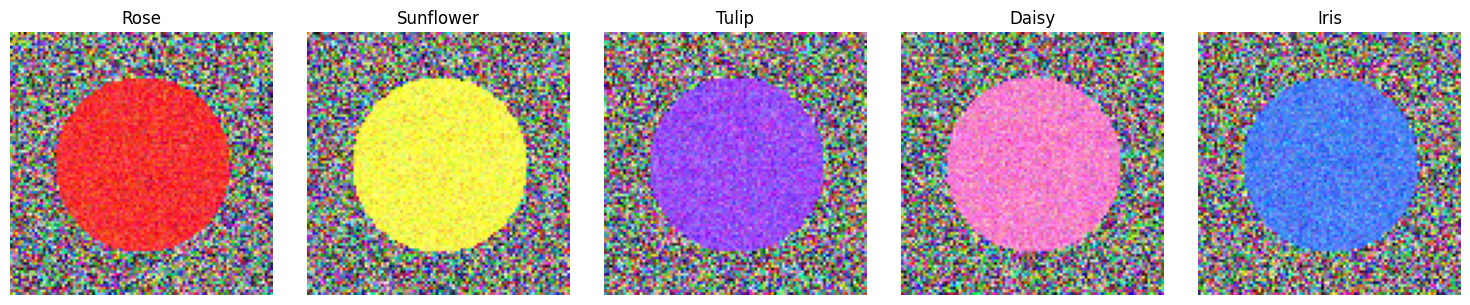

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 67.3MB/s]



MobileNetV2 caricato
Parametri base model: 3,504,872

Modello completo:
MobileNetTransfer(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, ker

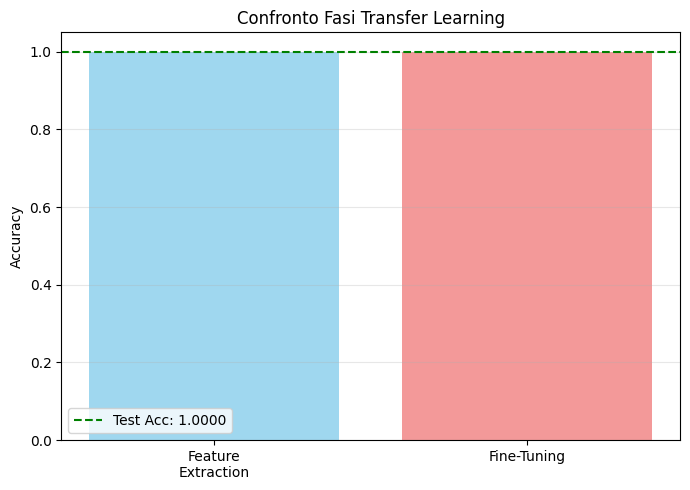

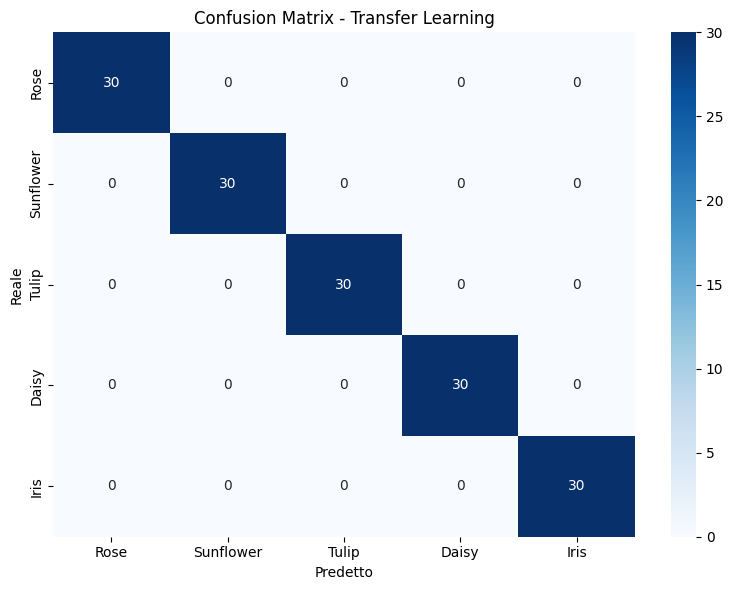


Classification Report:
              precision    recall  f1-score   support

        Rose       1.00      1.00      1.00        30
   Sunflower       1.00      1.00      1.00        30
       Tulip       1.00      1.00      1.00        30
       Daisy       1.00      1.00      1.00        30
        Iris       1.00      1.00      1.00        30

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150


Miglioramento da Feature Extraction a Fine-Tuning: 0.00%

Esercizio 4 completato!


In [16]:
# ==========================================================
# ESERCIZIO 4: Transfer Learning e Fine-Tuning
# ==========================================================
# Task: Usare MobileNetV2 pre-trained per classificazione
#       con fine-tuning
# Dataset: Flowers (1000 immagini, 5 classi di fiori)
#
# NOTA: variabili con suffisso _ex4

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Generazione dataset sintetico fiori
np.random.seed(999)

def generate_flower_images(n_samples, img_size=96, flower_type=0):
    images = np.random.rand(n_samples, img_size, img_size, 3).astype('float32')
    color_schemes = [
        [1.0, 0.2, 0.2],  # Rose - rosso
        [1.0, 1.0, 0.3],  # Sunflower - giallo
        [0.6, 0.3, 1.0],  # Tulip - viola
        [1.0, 0.5, 0.8],  # Daisy - rosa
        [0.3, 0.5, 1.0],  # Iris - blu
    ]
    for i in range(n_samples):
        center = img_size // 2
        for y in range(img_size):
            for x in range(img_size):
                dist = np.sqrt((x - center)**2 + (y - center)**2)
                if dist < img_size // 3:
                    images[i, y, x] = color_schemes[flower_type]
                    images[i, y, x] += np.random.randn(3) * 0.1
    images = np.clip(images, 0, 1)
    return images

flower_names = ['Rose', 'Sunflower', 'Tulip', 'Daisy', 'Iris']
samples_per_class = 200

X_flowers = []
y_flowers = []
for class_id, flower_name in enumerate(flower_names):
    images = generate_flower_images(samples_per_class, flower_type=class_id)
    X_flowers.append(images)
    y_flowers.extend([class_id] * samples_per_class)

X_flowers = np.vstack(X_flowers)
y_flowers = np.array(y_flowers)

indices_ex4 = np.random.permutation(len(X_flowers))
X_flowers = X_flowers[indices_ex4]
y_flowers = y_flowers[indices_ex4]

X_train_ex4, X_temp_ex4, y_train_ex4, y_temp_ex4 = (
    train_test_split(X_flowers, y_flowers, test_size=0.3, random_state=999, stratify=y_flowers)
)
X_val_ex4, X_test_ex4, y_val_ex4, y_test_ex4 = (
    train_test_split(X_temp_ex4, y_temp_ex4, test_size=0.5, random_state=999, stratify=y_temp_ex4)
)

print("Dataset Flowers")
print(f"Train: {X_train_ex4.shape}, Val: {X_val_ex4.shape}, Test: {X_test_ex4.shape}")
print(f"Classi: {flower_names}")

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    idx = np.where(y_train_ex4 == i)[0][0]
    axes[i].imshow(X_train_ex4[idx])
    axes[i].set_title(flower_names[i])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Step 1: Caricamento base model MobileNetV2
base_model_ex4 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Congela tutti i parametri
for param in base_model_ex4.parameters():
    raise NotImplementedError()

print(f"\nMobileNetV2 caricato")
print(f"Parametri base model: {sum(p.numel() for p in base_model_ex4.parameters()):,}")

# Step 2: Costruzione modello completo
class MobileNetTransfer(nn.Module):
    def __init__(self, base_model, num_classes=5):
        super().__init__()
        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        raise NotImplementedError()
        return x

model_transfer_ex4 = MobileNetTransfer(base_model_ex4).to(device)

print("\nModello completo:")
print(model_transfer_ex4)
print(f"Parametri totali: {sum(p.numel() for p in model_transfer_ex4.parameters()):,}")
print(f"Parametri trainable: {sum(p.numel() for p in model_transfer_ex4.parameters() if p.requires_grad):,}")

# Prepare data - normalize with ImageNet stats
def normalize_imagenet_from_float(X_np):
    """X_np: NHWC float32 [0,1] -> NCHW tensor normalized with ImageNet stats."""
    X_t = torch.from_numpy(X_np).permute(0, 3, 1, 2)
    for c in range(3):
        X_t[:, c] = (X_t[:, c] - imagenet_mean[c]) / imagenet_std[c]
    return X_t

X_tr_ex4_t = normalize_imagenet_from_float(X_train_ex4)
y_tr_ex4_t = torch.from_numpy(y_train_ex4).long()
X_val_ex4_t = normalize_imagenet_from_float(X_val_ex4)
y_val_ex4_t = torch.from_numpy(y_val_ex4).long()
X_test_ex4_t = normalize_imagenet_from_float(X_test_ex4)
y_test_ex4_t = torch.from_numpy(y_test_ex4).long()

train_loader_ex4 = DataLoader(TensorDataset(X_tr_ex4_t, y_tr_ex4_t), batch_size=32, shuffle=True)
val_loader_ex4 = DataLoader(TensorDataset(X_val_ex4_t, y_val_ex4_t), batch_size=32, shuffle=False)

# Step 3: Training fase 1 - solo classificatore
print("\nFASE 1: Training solo classificatore...")
history_phase1 = load_or_train(
    model_transfer_ex4,
    lambda: train_model(
        model_transfer_ex4, train_loader_ex4, val_loader_ex4,
        epochs=15, lr=0.001, patience=3, patience_lr=2
    ),
    'nb06_mobilenet_phase1.pt',
    device=device
)

_, val_acc_p1, _, _ = evaluate_model(model_transfer_ex4, X_val_ex4_t, y_val_ex4_t)
print(f"Fase 1 - Val Accuracy: {val_acc_p1:.4f}")

# Step 4: Fine-tuning - scongelare ultimi layer
# Unfreeze last 5 inverted residual blocks (features[-5:])
for i, block in enumerate(model_transfer_ex4.features):
    if i >= len(model_transfer_ex4.features) - 5:
        for param in block.parameters():
            raise NotImplementedError()

n_trainable = sum(p.numel() for p in model_transfer_ex4.parameters() if p.requires_grad)
print(f"\nParametri trainable dopo fine-tuning: {n_trainable}")

# Step 5: Training fase 2 - fine-tuning
print("\nFASE 2: Fine-tuning...")
history_phase2 = load_or_train(
    model_transfer_ex4,
    lambda: train_model(
        model_transfer_ex4, train_loader_ex4, val_loader_ex4,
        epochs=10, lr=0.0001, patience=3, patience_lr=2
    ),
    'nb06_mobilenet_phase2.pt',
    device=device
)

_, val_acc_p2, _, _ = evaluate_model(model_transfer_ex4, X_val_ex4_t, y_val_ex4_t)
_, test_acc_ex4, _, _ = evaluate_model(model_transfer_ex4, X_test_ex4_t, y_test_ex4_t)

print(f"\nFase 2 - Val Accuracy: {val_acc_p2:.4f}")
print(f"Test Accuracy finale: {test_acc_ex4:.4f}")

# Visualizzazione risultati
results_ex4 = pd.DataFrame({
    'Fase': ['Feature Extraction', 'Fine-Tuning'],
    'Val Accuracy': [val_acc_p1, val_acc_p2],
    'Miglioramento': [0, val_acc_p2 - val_acc_p1]
})

print("\n" + "=" * 70)
print("RISULTATI TRANSFER LEARNING")
print("=" * 70)
print(results_ex4.to_string(index=False))

# Plot learning curves entrambe le fasi
if history_phase1 is not None and history_phase2 is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    all_train_acc = history_phase1['accuracy'] + history_phase2['accuracy']
    all_val_acc = history_phase1['val_accuracy'] + history_phase2['val_accuracy']
    phase1_epochs = len(history_phase1['accuracy'])

    axes[0].plot(range(len(all_train_acc)), all_train_acc, label='Train')
    axes[0].plot(range(len(all_val_acc)), all_val_acc, label='Validation')
    axes[0].axvline(x=phase1_epochs, color='r', linestyle='--', label='Inizio Fine-Tuning')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Learning Curves: Feature Extraction + Fine-Tuning')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    phases = ['Feature\nExtraction', 'Fine-Tuning']
    val_accs_ex4 = [val_acc_p1, val_acc_p2]
    colors_ex4 = ['skyblue', 'lightcoral']

    axes[1].bar(phases, val_accs_ex4, color=colors_ex4, alpha=0.8)
    axes[1].axhline(y=test_acc_ex4, color='green', linestyle='--', label=f'Test Acc: {test_acc_ex4:.4f}')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Confronto Fasi Transfer Learning')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Using pretrained weights - training curves not available")
    phases = ['Feature\nExtraction', 'Fine-Tuning']
    val_accs_ex4 = [val_acc_p1, val_acc_p2]
    colors_ex4 = ['skyblue', 'lightcoral']
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.bar(phases, val_accs_ex4, color=colors_ex4, alpha=0.8)
    ax.axhline(y=test_acc_ex4, color='green', linestyle='--', label=f'Test Acc: {test_acc_ex4:.4f}')
    ax.set_ylabel('Accuracy')
    ax.set_title('Confronto Fasi Transfer Learning')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

_, _, y_pred_ex4, _ = evaluate_model(model_transfer_ex4, X_test_ex4_t, y_test_ex4_t)

cm_ex4 = confusion_matrix(y_test_ex4, y_pred_ex4)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_ex4, annot=True, fmt='d', cmap='Blues',
    xticklabels=flower_names,
    yticklabels=flower_names
)
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Confusion Matrix - Transfer Learning')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_ex4, y_pred_ex4, target_names=flower_names))

improvement = (val_acc_p2 - val_acc_p1) * 100
print(f"\nMiglioramento da Feature Extraction a Fine-Tuning: {improvement:.2f}%")

print("\nEsercizio 4 completato!")
